In [1]:
import warnings
from multiprocessing import Pool
from pathlib import Path
import json

import numpy as np  
from scipy.interpolate import RegularGridInterpolator

# Support for interactive widgets
from IPython.display import *
from ipywidgets import Dropdown

# %matplotlib widget 
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad

from deblib.constants import c

from dust_extinction.parameter_averages import F99, F04, G23

import emcee
from emcee.autocorr import AutocorrError
import corner

from libs.mcmc_sed import ln_prob, blackbody_model, min_max_normalize
from libs.mcmc_sed import mist_isos
from libs.pipeline import get_sed_for_target, get_bayestar_ebv_for_coords, get_vergely_av_for_coords

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Reading in: /home/steveo/projects/main/platodebcat/libs/data/mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso


/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


### Load the NewEra model spectra modelling function

First we load the pre-built data arrays of NewEra spectra which have been parsed and saved with
the `newera_spectra_to_interp3d.py` module. These are saved in a form which can be used with the
scipy [`interpn`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html)
multidimensional interpolation function or, for better performance over multiple calls, the
[`RegularGridInterpulator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html#scipy.interpolate.RegularGridInterpolator)
class.

The data space has three axes for $T_{\rm eff}$, $\log{g}$ and freqency (published as 1d numpy
arrays named `teffs`, `loggs` and `freqs`), and the datapoints are the flux values (a 3d array 
numpy array named `V`).

In [2]:
spec_data = np.load("libs/data/newera/PHOENIX-NewEra-for-interp3d.npy.npz", allow_pickle=True)
interp3d = RegularGridInterpolator(points=(spec_data["teffs"], spec_data["loggs"], spec_data["freqs"]),
                                   values=spec_data["V"])

ne_teff_range = (spec_data["teffs"].min(), spec_data["teffs"].max()) * u.K
ne_logg_range = (spec_data["loggs"].min(), spec_data["loggs"].max()) * u.dex
ne_wl_range = c * 1e6 / (spec_data["freqs"].max(), spec_data["freqs"].min()) * u.um
print(f"Loaded previously built 3d dataset of Z=0 NewEra spectra covering the ranges")
print(f"wavelength {ne_wl_range}, Teff {ne_teff_range} and logg {ne_logg_range}")
del spec_data

Loaded previously built 3d dataset of Z=0 NewEra spectra covering the ranges
wavelength [1.000e-02 2.999e+01] um, Teff [ 2300. 12000.] K and logg [0.5 6. ] dex


This is the MCMC model function based on the NewEra spectral data loaded above. It returns a
two arrays of synthetic SED flux values, at the requested frequencies `x`, for two stars with
the requested Teff/logg combinations.

In [3]:
def newera_model(x, Teff1, Teff2, logg1, logg2):
    def newera_spectrum(teff, logg):
        # We can interpolate for multiple values in one hit;
        # in this case we want multiple frequencies for a single Teff/logg combo
        xi = np.array([[teff, logg, freq] for freq in x])

        # Get the fluxes based on a 3d interpolation for the chosen Teff, logg and frequencies (xi)
        return interp3d(xi, method="linear")
    return ( newera_spectrum(Teff1, logg1), newera_spectrum(Teff2, logg2) )

### Set up the extinction model

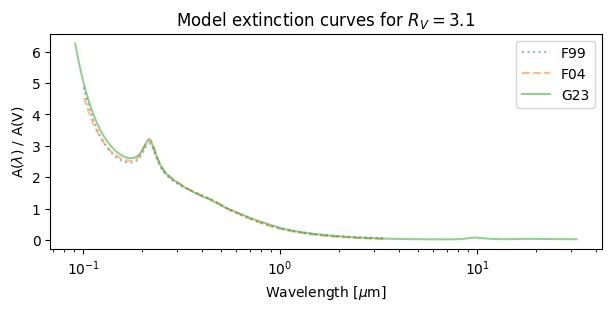

Using the G23 extinction model covers the range from 0.0912 um to 32.0 um.


In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
for (_mod, _ls) in [(F99, ":"), (F04, "--"), (G23, "-")]:
    _lambda = (1 / np.logspace(*np.log10(_mod.x_range), num=1000)) * u.um
    ax.plot(_lambda, _mod(Rv=3.1)(_lambda), ls=_ls, alpha=0.5, label=f"{_mod.name}")
ax.set(title=f"Model extinction curves for $R_V=3.1$", xscale="log",
       xlabel=r"Wavelength [$\mu$m]", ylabel=r"A($\lambda$) / A(V)")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

# The G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model covers the range from",
      f"{min(ext_wl_range)} to {max(ext_wl_range)}.")

### Select our target and get its known information

In [5]:
default_target = "CM Dra"
targets_config_file = Path.cwd() / "config" / "fitting-a-sed-targets.json"
with open(targets_config_file, mode="r", encoding="utf8") as f:
    full_dict = json.load(f)
targets_cfg = { k: full_dict[k] for k in full_dict if full_dict[k].get("enabled", True) }

max_teff = max(ne_teff_range).value
options = [
    (f"{t}" + (" *" if c.get("exclude", False) else "") + (" [too hot!]" if min(c["TeffA"], c["TeffB"]) > max_teff else ""), t)
        for t, c in targets_cfg.items()
]

target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=31, options=(('V436 Per [too hot!]', 'V436 Per'), ('V539 Ara [too hot!]…

In [6]:
target = target_selection.value
target_config = targets_cfg[target]
search_term = target_config.get("search_term", target)
k, k_err = target_config.get("k"), target_config.get("k_err", 0)

# We need the coordinates and approximate distance for extinction lookups
simbad = Simbad()
simbad.add_votable_fields("parallax")
if _tbl := simbad.query_object(search_term):
    target_coords = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit,
                             dec=_tbl["dec"][0] * _tbl["dec"].unit,
                             distance=1000 / _tbl["plx_value"][0] * u.pc)
    print(f"{target} SkyCoords are {target_coords}")

ZZ Boo SkyCoords are <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (209.03965653, 25.91870915, 106.44412748)>


### Get the SED data for the target
- apply default uncertainties to those measurements with none
- exclude measurements outside the range of our extinction model
- exclude outliers

In [ ]:
# Read in the SED for this target
sed = get_sed_for_target(target, search_term, radius=0.1)

# Filter SED to those covered by our models and also remove any outliers
model_mask = (sed["sed_wl"] >= min(ext_wl_range)) & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(ne_wl_range)) & (sed["sed_wl"] <= max(ne_wl_range))

out_mask = sed["sed_filter"] == "HIP:hp"    # These tend to give outliers at ~0.402 um
if "CW Eri" in target or "V788 Cen" in target:
    out_mask |= sed["sed_filter"] == "Cousins:I"
if "CM Dra" in target:
    out_mask |= sed["sed_wl"] > 20 * u.um
if "ZZ Boo" in target:
    out_mask |= sed["sed_filter"] == "PAN-STARRS/PS1:y"

sed = sed[model_mask & ~out_mask]

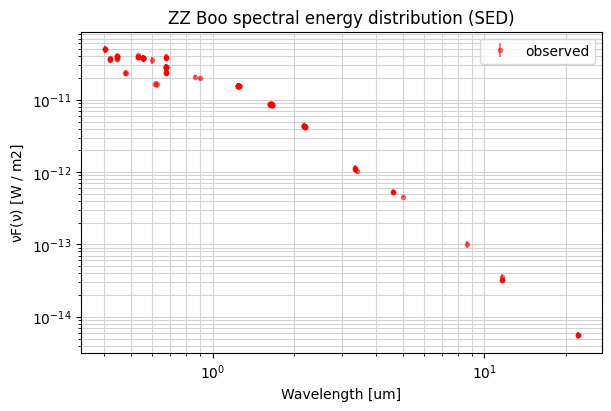

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"], sed["sed_vfv"], sed["sed_evfv"], fmt=".r", alpha=0.5, label="observed")
ax.set(title=f"{target} spectral energy distribution (SED)",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed['sed_vfv'].unit}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### De-redden the SED

In [9]:
# Lookup the target's extinction in Bayestar (and fall back on the Vergely maps)
Ebv, _flags = get_bayestar_ebv_for_coords(target_coords, "bayestar2019")
print(f'For {target} the bayestar2019 extinction is: E(B-V) = {Ebv:.6f} mag',
    '( diagnostic flags:', ', '.join(f'{n} = {_flags[n]}' for n in _flags), ')')
if Ebv and not np.isnan(Ebv) and _flags.get("converged", False):
    sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=Ebv)
    der_lab = f"dereddened\n(E(B-V)={Ebv:.6f})"    
elif Av := get_vergely_av_for_coords(target_coords):
    print(f"For {target} the extinction is: Av = {Av:.6f}")
    sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Av=Av)
    der_lab = f"dereddened\n($A_v={Av:.6f}$)"
else:
    print(f"!!!No de-reddening found!!!")
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"
sed["sed_der_vfv"] = sed["sed_der_flux"] * sed["sed_freq"] * u.Hz

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 24.895 s
  pix_info:   0.339 s
   samples:  14.265 s
      best:   2.662 s
       nan:   0.016 s
      sort:   7.549 s
       idx:   0.064 s
For ZZ Boo the bayestar2019 extinction is: E(B-V) = 0.000000 mag ( diagnostic flags: converged = True, reliable_dist = False )
Querying Galactic interstellar dust Gaia-2MASS 3D maps (2022A&A...664A.174V) for extinction data.
For ZZ Boo the extinction is: Av = 0.001926


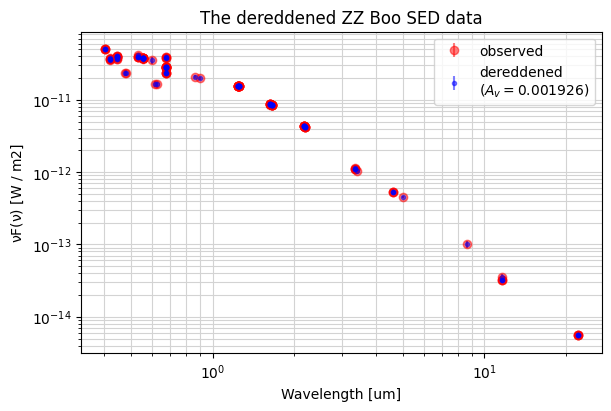

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"], sed["sed_vfv"], sed["sed_evfv"], fmt="or", alpha=0.5, label="observed")
ax.errorbar(sed["sed_wl"], sed["sed_der_vfv"], sed["sed_evfv"], fmt=".b", alpha=0.5, label=der_lab)
ax.set(title=f"The dereddened {target} SED data",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed['sed_der_vfv'].unit}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### Set up the MCMC functions

#### The MCMC functions
- `lnlike` is the _likelihood function_ which compares the model spectra with the observed data (both normalized)
- `lnprior` contains any _prior knowledge_ we have about the parameters from elsewhere
  - in this case there are restrictions on stellar age/phase and a known ratio of radii from LC fitting
  - also returns a blob containing the two stars' $T_{\rm eff}$ and $\log{g}$ values for masses and age being sampled
- `lnprob` combines the two into a probability density

In [11]:
MIN_MASS, MAX_MASS = 0.1, 270.      # realistic MIST mass and log10(age) ranges
MIN_AGE, MAX_AGE = min(mist_isos.list_ages(feh=0)), max(mist_isos.list_ages(feh=0))
MIN_PHASE, MAX_PHASE = 0.0, 2.0     # MIST main sequence to RGB phases
MIN_TEFF, MAX_TEFF = ne_teff_range.value
MIN_LOGG, MAX_LOGG = ne_logg_range.value
MIST_PRIOR_PARAMS = ["Teff", "log_g", "R", "phase"]

def ln_prior(MA: float, MB: float, age: float, k: float):
    """
    The MCMC log prior function which evaluates the properties of the stars defined by
    the current masses and age against known prior constraints.
    """
    # pylint: disable=too-many-locals
    TeffA, TeffB, loggA, loggB = None, None, None, None
    retval = -np.inf # failure

    # Basic validation of priors; lookup won't work if these are out of range of MIST values
    if MIN_MASS <= MA <= MAX_MASS and MIN_MASS <= MB <= MAX_MASS and MIN_AGE <= age <= MAX_AGE:
        try:
            # Get the stellar params to evaluate, plus the Teffs/logg are req'd to generate SEDs
            TeffA, loggA, RA, phA = mist_isos.stellar_params_for_mass(0, age, MA, MIST_PRIOR_PARAMS)
            TeffB, loggB, RB, phB = mist_isos.stellar_params_for_mass(0, age, MB, MIST_PRIOR_PARAMS)

            # Evaluate the stellar params against the priors.
            # For k (ratio of radii) is supplied and is specific to this target.
            if np.abs((RB / RA) - k) < 0.1 \
                and min(phA, phB) >= MIN_PHASE and max(phA, phB) <= MAX_PHASE \
                and min(TeffA, TeffB) >= MIN_TEFF and max(TeffA, TeffB) <= MAX_TEFF \
                and min(loggA, loggB) >= MIN_LOGG and max(loggA, loggB) <= MAX_LOGG:
                retval = 0 # params conform to the priors
        except ValueError:
            pass
    return retval, (TeffA, TeffB, loggA, loggB)

#### Prepare and run the MCMC

In [12]:
nwalkers = 100
niters = 100000

# Starting position for the search
init_MA, init_MB, init_age = 1.0, 1.0, 9.0
print(f"Starting point:\nMA = {init_MA} M_sun\nMB = {init_MB} M_sun\nlog(age) = {init_age}")

rng = np.random.default_rng(42)
initial = np.array([init_MA, init_MB, init_age])
ndim = len(initial)
p0 = [initial + rng.normal(0, 0.1, ndim) for _ in range(nwalkers)]

# Fitting will be based on a normalized copy of the dereddened fluxes
sed["sed_norm_flux"], sed["sed_norm_eflux"] = min_max_normalize(sed["sed_der_flux"].value,
                                                                sed["sed_eflux"].value)

# These are the "fixed" kwargs which will be sent to the MCMC ln_prob function
kwargs = {
    "x": sed["sed_freq"].value,
    "y": sed["sed_norm_flux"].value,
    "y_err": sed["sed_norm_eflux"].value,
    "k": k,
    "ln_prior_func": ln_prior,
    "model_func": newera_model,
}

Starting point:
MA = 1.0 M_sun
MB = 1.0 M_sun
log(age) = 9.0


In [13]:
with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore") #, message="(?:.*)invalid value encountered in scalar subtract")
    with Pool(processes=None) as pool:
        print(f"Running MCMC for {niters:,} iterations with {nwalkers} walkers.")
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=ln_prob, kwargs=kwargs, pool=pool)
        state = sampler.run_mcmc(p0, niters, progress=True)

Running MCMC for 100,000 iterations...


100%|██████████| 100000/100000 [19:09<00:00, 87.00it/s]


In [14]:
accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction: {accept_frac:.6f}")

try:
    # autocorrelation time; steps to effectively "forget" start position
    tau = sampler.get_autocorr_time()
    print(f"Autocorrelation steps:   ", ", ".join(f"{t:.3f}" for t in tau))
except AutocorrError as err:
    print(f"\033[93m\033[1m{err}\033[0m")
    tau = err.tau

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


Mean Acceptance fraction: 0.319077
Autocorrelation steps:    nan, 732.548, nan


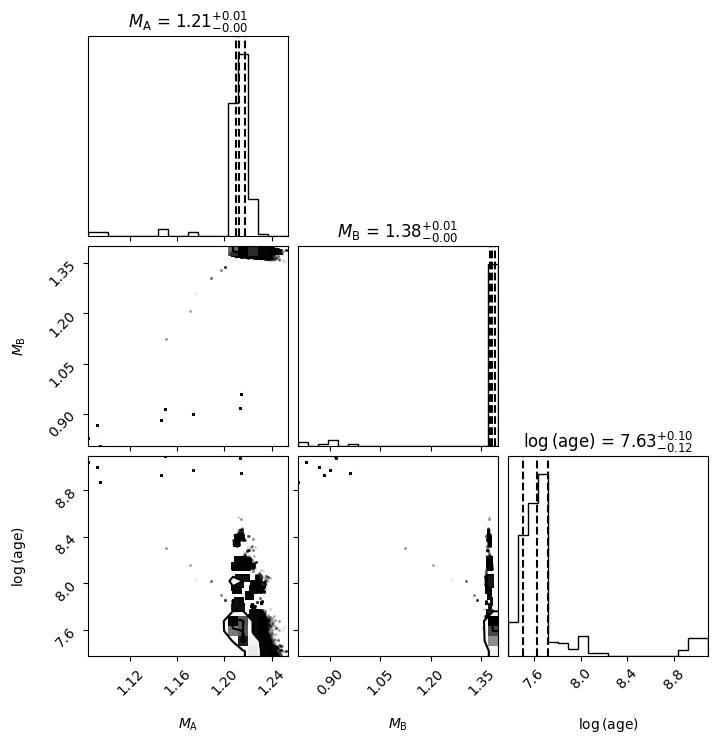

In [15]:
warm_discard = int(np.mean(np.nan_to_num(tau, copy=True, nan=1000))) * 2
thin = max(1, int(1 / (1-max(accept_frac, 0.1))))

# thin; every nth step from the chain
samples = sampler.get_chain(discard=warm_discard, thin=thin, flat=True)
labels = [r"$M_{\rm A}$", r"$M_{\rm B}$", r"$\log{({\rm age})}$"]
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])

In [16]:
# Gets the median fitted values (currently M1, M2 and log(age))
fitted_vals = np.median(samples, axis=0)
fitted_high = np.quantile(samples, 0.84, axis=0) - fitted_vals
fitted_low = fitted_vals - np.quantile(samples, 0.16, axis=0)

print(f"Best fit parameters for {target} from {niters:,} MCMC iterations")
for ix, (k, unit) in enumerate([("MA", u.solMass), ("MB", u.solMass), ("age", u.dex(u.yr))]):
    print(f"{k:>9s} = {fitted_vals[ix]:.3f} +/- {fitted_high[ix]:.3f}/{fitted_low[ix]:.3f} {unit}",
          f"(known value {target_config.get(k, np.NaN)} +/- {target_config.get(k+'_err', '')})")

Best fit parameters for ZZ Boo from 100,000 MCMC iterations
       MA = 1.212 +/- 0.005/0.003 solMass (known value 1.558 +/- 0.008)
       MB = 1.381 +/- 0.009/0.005 solMass (known value 1.599 +/- 0.012)
      age = 7.628 +/- 0.095/0.120 dex(yr) (known value 9.2 +/- )


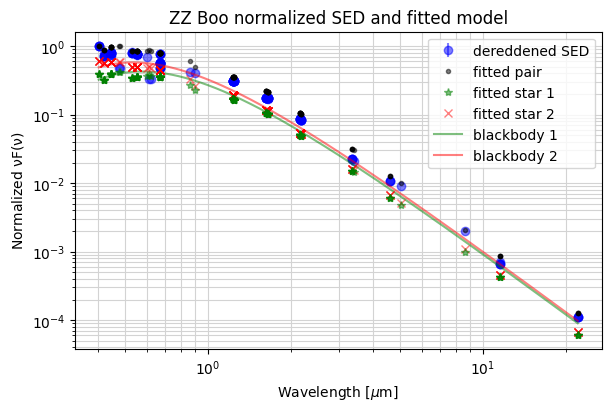

In [17]:
# Need to get the effective temperatures & logg for these masses/age combinations
MA, MB, log_age = fitted_vals
teffA, loggA = mist_isos.stellar_params_for_mass(0, log_age, MA, ["Teff", "log_g"])
teffB, loggB = mist_isos.stellar_params_for_mass(0, log_age, MB, ["Teff", "log_g"])

# TODO: some weirdness in the above calls which gives a negative logg value
if loggA < 0:
    print(f"Overiding loggA value of {loggA}")
    loggA = 4.0

# Generate a model SED from the fitted values for plotting
sed_freq = sed["sed_freq"].value
mod_star_vfv = newera_model(sed_freq, teffA, teffB, loggA, loggB) * sed_freq
mod_comb_vfv = np.add(*newera_model(sed_freq, teffA, teffB, loggA, loggB)) * sed_freq
mod_norm_scale = mod_comb_vfv.max() - mod_comb_vfv.min()

# lambdas/freqs for getting fluxes and plotting contiguous lines (rather than points of sed_lambda)
cont_lambda = np.logspace(np.log10(sed["sed_wl"].min()), np.log10(sed["sed_wl"].max()), 1000)
cont_freq = c*1e6 / cont_lambda

# Set up BB model curves for comparison
bb_star_vfv = blackbody_model(cont_freq, teffA, teffB) * cont_freq
bb_comb_vfv = np.add(*blackbody_model(cont_freq, teffA, teffB)) * cont_freq
bb_norm_scale = bb_comb_vfv.max() - bb_comb_vfv.min()

# Get the dereddened observed SED data
sed_norm_scale = sed["sed_vfv"].max() - sed["sed_vfv"].min()

# Plot the fitted model against the derredened SED + show each star's contribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
for (lam,           flux,              eflux,           norm_scale,         fmt,    z,      label) in [
    (sed["sed_wl"], sed["sed_vfv"],    sed["sed_evfv"], sed_norm_scale,     "ob",   10,     "dereddened SED"),
    (sed["sed_wl"], mod_comb_vfv,      None,            mod_norm_scale,     ".k",   90,     "fitted pair"),
    (sed["sed_wl"], mod_star_vfv[0],   None,            mod_norm_scale,     "*g",   80,     "fitted star 1"),
    (sed["sed_wl"], mod_star_vfv[1],   None,            mod_norm_scale,     "xr",   70,     "fitted star 2"),
    (cont_lambda,   bb_star_vfv[0],    None,            bb_norm_scale,      "-g",   60,     "blackbody 1"),
    (cont_lambda,   bb_star_vfv[1],    None,            bb_norm_scale,      "-r",   50,     "blackbody 2"),
]:
    # Rather than (flux-min(flux))/norm_scale we plot flux/norm_scale so that we don't loose the lowest value to zero
    ax.errorbar(lam, (flux)/norm_scale, eflux, fmt=fmt, alpha=0.5, zorder=z, label=label)
ax.set(title=f"{target} normalized SED and fitted model",
       xlabel=r"Wavelength [$\mu$m]", ylabel=r"Normalized ${\rm \nu F(\nu)}$", xscale="log", yscale="log")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)